In [1]:
import numpy as np
from typing import List, Tuple
from numpy.typing import ArrayLike
from nn import NeuralNetwork, one_hot_encode_seqs, sample_seqs,read_text_file,read_fasta_file, clip_sample_seqs
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
rap1 = read_text_file("./data/rap1-lieb-positives.txt")
yeast_neg = read_fasta_file("./data/yeast-upstream-1k-negative.fa")

# Sampling Scheme: Upsampling
* I chose to upsample the minority class to keep the dataset large enough to successfuly train a neural network, which needs a lot of data, while keeping the classes balanced. An alternative approach, like downsampling, would have kept 137 positive and 137 negative data points, which would have been a significant reduction in the sample size, possibly leading to a poorly trained model.
* The upsampling procedure is implemented via sampling with replacement of the minority class, while keeping all members of the majority class. In this case, the positive positive Rap1 motifs will be resampled with replacement until there are an equal number of positive and negative motifs (3163 of each)
* However, because the yeast negative sequences are much longer than the positive rap1 motifs, the dimensions of the two datasets are different. Therefore, I implemented clip_sample_seqs() to take the longer yeast negative sequences and clip/chunk each of them to produce multiple sequences of the same length as the rap1 motifs. Therefore, the 3163 yeast negative motifs ended up turning into far more smaller sequences that are the same length as the rap1 positive motifs. Upsampling therefore led to 366594 total sequences, with an equal 183297 in each class.
* The resulting clipped yeast negative sequences and upsamples rap1 positive sequences were one hot encoded and used to train the classifier.

In [3]:
np.random.seed(42)
pos,neg = clip_sample_seqs(rap1,yeast_neg)
#concatenate positive and negative and create a list of labels
seqs = pos + neg
labels = [True] * len(pos) + [False]*len(neg)

X,y = sample_seqs(seqs,labels,random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = one_hot_encode_seqs(X_train)
X_train = np.stack(X_train,axis=0) #convert list of np arrays back into a 2D array

X_test = one_hot_encode_seqs(X_test)
X_test = np.stack(X_test,axis = 0)

### 5-fold CV Grid Search to find optimal learning rate and activation function hyperparameters


In [4]:
columns = ["lr","activation_layer1","avg_train_error","avg_val_error"] + [f"train_error_fold_{x}" for x in range(1,6)] \
         + [f"val_error_fold_{x}" for x in range(1,6)]            
tuning_results_df = pd.DataFrame(columns = columns)
lrs = [0.01,0.001,0.0001]
activations = ['relu','sigmoid']                                              
kf = KFold(n_splits=5)
df_idx = 0
for lr in lrs:
    for activation_layer1 in activations:
        fold_avg_train_losses = []
        fold_avg_val_losses = []
        for fold_idx, (train,val) in enumerate(kf.split(X_train,y_train)):
            fold_idx = fold_idx + 1
            nn = NeuralNetwork(nn_arch=[{'input_dim': 68, 'output_dim': 16, 'activation': activation_layer1},
                           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}],
                           lr=lr, batch_size=10000, seed=42, epochs=20, loss_function=
                           'cross_entropy') 
            #fit this fold. test data is still held out
            train_loss, val_loss = nn.fit(X_train[train],y_train[train],
                                           X_train[val],y_train[val])
            fold_avg_train_loss = np.mean(train_loss) #avg (across epochs) training loss for this fold
            fold_avg_train_losses.append(fold_avg_train_loss)

            fold_avg_val_loss = np.mean(val_loss) #avg (across epochs) validation loss for this fold
            fold_avg_val_losses.append(fold_avg_val_loss)


            #store hyperparameters and per-fold results
            tuning_results_df.loc[df_idx,"lr"] = lr
            tuning_results_df.loc[df_idx,"activation_layer1"] = activation_layer1
            tuning_results_df.loc[df_idx,f"train_error_fold_{fold_idx}"] = fold_avg_train_loss
            tuning_results_df.loc[df_idx,f"val_error_fold_{fold_idx}"] = fold_avg_val_loss

        #store average train and val loss across all folds for this combination of hyperparameters
        tuning_results_df.loc[df_idx,"avg_train_error"] = np.mean(fold_avg_train_losses)
        tuning_results_df.loc[df_idx,"avg_val_error"] = np.mean(fold_avg_val_losses)

        df_idx +=1

/Users/shirondrusinsky/Documents/GitHub/project7/nn/nn.py:374: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-Z))


In [5]:
#resulting dataframe stores error from each fold with each combination of hyperparameters
#as well as the average error across all 5 folds with each combnation of hyperparameters
display(tuning_results_df)

,lr,activation_layer1,avg_train_error,avg_val_error,train_error_fold_1,train_error_fold_2,train_error_fold_3,train_error_fold_4,train_error_fold_5,val_error_fold_1,val_error_fold_2,val_error_fold_3,val_error_fold_4,val_error_fold_5
0,0.01,relu,8.077032,8.091007,8.072329,8.091333,8.068603,8.070403,8.082492,8.119866,8.086454,8.095683,8.097568,8.055463
1,0.01,sigmoid,8.09472,8.108544,8.089832,8.10139,8.090546,8.090429,8.101402,8.136999,8.096355,8.117503,8.117547,8.074319
2,0.001,relu,2.064486,2.066429,0.374077,8.320583,0.531658,0.541534,0.554577,0.374906,8.319616,0.536058,0.541484,0.560084
3,0.001,sigmoid,1.075321,1.076088,1.073555,1.076047,1.075567,1.075815,1.075621,1.074864,1.076622,1.076268,1.07644,1.076246
4,0.0001,relu,0.011881,0.010572,0.011877,0.01191,0.011959,0.011836,0.011821,0.010691,0.010573,0.010259,0.010619,0.01072
5,0.0001,sigmoid,0.039006,0.037656,0.038969,0.038993,0.039086,0.038976,0.039004,0.037885,0.037808,0.037349,0.037656,0.03758


In [6]:
#get data for combination of hyperparameters that gave the lowest average binary cross entropy
# across epochs and folds in the validation set
display(tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin()])
best_lr = tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin(),'lr']
best_activation_layer1 = tuning_results_df.loc[tuning_results_df['avg_val_error'].astype(float).idxmin(),'activation_layer1']

print(f"The optimal learning rate was {best_lr}")
print(f"The optimal activation function to use in layer 1 was {best_activation_layer1}")


lr                      0.0001
activation_layer1         relu
avg_train_error       0.011881
avg_val_error         0.010572
train_error_fold_1    0.011877
train_error_fold_2     0.01191
train_error_fold_3    0.011959
train_error_fold_4    0.011836
train_error_fold_5    0.011821
val_error_fold_1      0.010691
val_error_fold_2      0.010573
val_error_fold_3      0.010259
val_error_fold_4      0.010619
val_error_fold_5       0.01072
Name: 4, dtype: object

The optimal learning rate was 0.0001
The optimal activation function to use in layer 1 was relu


### Re-training model with optimal set of hyperparameters and plotting per-epoch train and test binary cross entropy

* I chose learning rate and activation function hyperparameters by implementing a cross-validated grid search; the hyperparameters that minimized the average across-fold binary cross entropy were used moving forward. A subset of samples were completely held out from this procedure to be used for validation/testing later in this notebook. 
* These results suggest the model was able to learn from the training data and properly generalize to the unseen  data, as the unseen validation loss decreased over the epochs


### Why I chose Binary Cross Entropy as my loss function
* Binary cross entropy was chosen as the loss function because this loss is minimized with correct binary classifications -- when a member of the 1 class is properly classified as a 1 or when a member of the 0 class is properly classified as a 0. Therefore, the goal of backpropagation is to minimize this loss. Using a different loss function, like mean squared error would be inappropriate because this loss is more appropriate for regression-like tasks rather than classification.

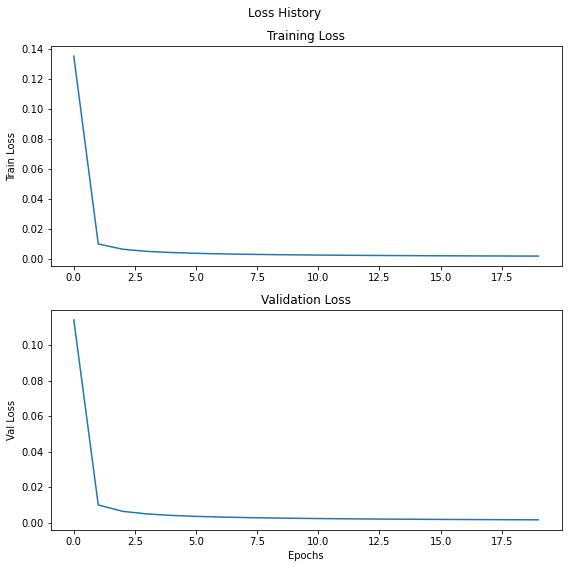

In [7]:
#instantiate NN with best learning rate and layer 1 activation function
#determined via grid search
nn = NeuralNetwork(nn_arch=[{'input_dim': 68, 'output_dim': 16, 'activation': best_activation_layer1},
                           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}],
                           lr=best_lr, batch_size=10000, seed=42, epochs=20, loss_function=
                           'cross_entropy') 
#X_train and y_train are the same observations that were used for cross validation grid search
#X_test and y_test were completely held out of the grid search procedure
per_epoch_train_loss, per_epoch_val_loss = nn.fit(X_train,y_train,
                                               X_test,y_test)



loss_hist = per_epoch_train_loss
loss_hist_val = per_epoch_val_loss
assert len(loss_hist) > 0, "Need to run training before plotting loss history"
fig, axs = plt.subplots(2, figsize=(8,8))
fig.suptitle('Loss History')
axs[0].plot(np.arange(len(loss_hist)), loss_hist)
axs[0].set_title('Training Loss')
axs[1].plot(np.arange(len(loss_hist_val)), loss_hist_val)
axs[1].set_title('Validation Loss')
plt.xlabel('Epochs')
axs[0].set_ylabel('Train Loss')
axs[1].set_ylabel('Val Loss')
fig.tight_layout()
plt.show() 

### Performance of the Classifier on the test dataset
* Take the trained model and quantify binary cross entropy error and accuracy on the held out test dataset
* Also plot an ROC-AUC curve from the held out test data

In [8]:
predictions = nn.predict(X_test)
test_bce = nn._binary_cross_entropy(y_test,predictions)
print(f"Average binary cross entropy error across held out test data {test_bce}")

#ROC curve
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_test.reshape(y_test.shape[0],1).astype(int),
         predictions)

#to get accuracy, I need to convert binarize predictions, which are given as probabilities
# I will binarize by calling every probability >= 0.5 as 1, and everything <0.5 0
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0
predictions = predictions.astype(int)

y_test = y_test.reshape(y_test.shape[0],1) #reshape to have compatible as predictions
y_test = y_test.astype(int)

test_accuracy = np.sum(predictions==y_test)/len(y_test)
print(f"Test Accuracy: {test_accuracy}")


Average binary cross entropy error across held out test data 5.771624477093937
Test Accuracy: 0.9997272231314784


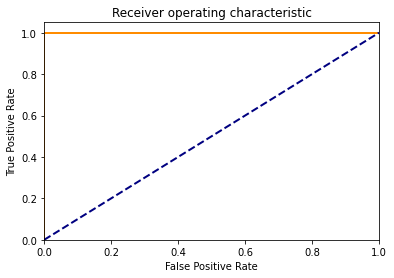

In [9]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.show()

# Conclusions
* Classifier had excellent performance, as seen through a nearly perfect ROC curve  and high accuracy on the held-out test set with balanced classes.